In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import quadprog as qp
import matplotlib.pylab as plt
import scipy.optimize as opt

In [2]:
bond_df = pd.read_csv('./Data/sample-bonds-1.csv')
bond_df.head()

,coupon,dirty price,maturity,pd-1,pd-2,pd-3,pd-4,pd-5,pd-6,pd-7,pd-8,pd-9
0,2.375,101.9825,5/15/2018,11/15/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.250,105.4372,12/15/2019,6/15/2019,12/15/2018,6/15/2018,12/15/2017,NaN,NaN,NaN,NaN,NaN
2,1.875,101.7911,1/15/2020,7/15/2019,1/15/2019,7/15/2018,1/15/2018,NaN,NaN,NaN,NaN,NaN
3,1.375,98.9160,3/31/2021,9/30/2020,3/31/2020,9/30/2019,3/31/2019,9/30/2018,3/31/2018,NaN,NaN,NaN
4,4.125,110.0907,10/15/2022,4/15/2022,10/15/2021,4/15/2021,10/15/2020,4/15/2020,10/15/2019,4/15/2019,10/15/2018,4/15/2018


In [3]:
T0 = dt.datetime(2017,11,7)
pd = [ [(dt.datetime.strptime(x,'%m/%d/%Y')-T0).days if type(x) is str else 0 for j,x in item.iteritems()] for i, item in bond_df.iloc[:,2:].iterrows()]

In [4]:
u_pd = np.unique(np.ravel(pd))
u_pd = u_pd[np.where(u_pd>0)]
n = len(bond_df)
m = len(u_pd)
print('%d bonds and %d cashflow dates' % (n,m) )

5 bonds and 29 cashflow dates


In [5]:
p = np.array(bond_df['dirty price'])
C = np.zeros( (n,m) )
for i in range(n):
    c = 0.5*bond_df.iloc[i,0]
    for k,x in enumerate(pd[i]):
        if x>0:
            j = np.where(u_pd==x)[0][0]
            C[i,j] = c if k > 0 else 100+c

In [6]:
class TensionSpline(object):
    def __init__(self, ti, yi, tension):
        self.ti = ti
        self.yi = yi
        ni = len(yi)
        self.dt = np.diff(ti)
        assert(np.min(self.dt) > 0)
        self.sigma = tension / np.max(self.dt)
        dydt = np.diff(yi)/self.dt
        self.tau = self.sigma * self.dt
        s1 = 1.0 / (self.dt * self.sigma**2)
        s2 = -2*self.dt*np.exp(-self.tau)/(self.tau*np.expm1(-2*self.tau))

        n = ni - 2
        w = self.dt / (self.tau*np.tanh(self.tau)) - s1
        sdiag = s1[1:n] - s2[1:n]
        diag = w[:n] + w[1:] 
        b = np.diff(dydt)
        T = np.diag(sdiag,-1) + np.diag(sdiag,1) + np.diag(diag)
        self.ypps = np.zeros(ni)
        self.ypps[1:1+n] = np.linalg.solve(T,b)
        
    # interpolation function uses ti, yi, dt, tau, sigma, ypps    
    def __call__(self, t_):
        t = t_*np.ones(1) if np.isscalar(t_) else t_
        res = np.zeros(np.shape(t))
        res[np.where(t<=self.ti[0])] = self.yi[0]
        res[np.where(t>=self.ti[-1])] = self.yi[-1]
        gi = np.where( (self.ti[0] < t) & (t < self.ti[-1]) )
        tg = t[gi]
        ii = np.array([np.argmin(self.ti<tx) for _, tx in enumerate(tg)])
        u = (self.ti[ii] - tg) / self.dt[ii-1]
        v = 1-u
        den = -np.expm1(-2*self.tau[ii-1])
        eum = np.exp( (u-1)*self.tau[ii-1] )
        eup = np.exp(-(u+1)*self.tau[ii-1] )
        evm = np.exp( (v-1)*self.tau[ii-1] )
        evp = np.exp(-(v+1)*self.tau[ii-1] )
    
        sig2 = self.sigma**2
        p = ( ((eum - eup) / den) - u ) / sig2
        q = ( ((evm - evp) / den) - v ) / sig2
        g = self.ypps[ii-1]*p + self.ypps[ii]*q
        res[gi] = u*self.yi[ii-1] + v*self.yi[ii] + g
    
        return res[0] if np .isscalar(t_) else res

In [7]:
class CurveObjective:
    def __init__(self, C, p, u_pd, tension):
        self.C = C
        self.p = p
        self.t = u_pd / 365.0
        self.tension = tension
        self.knots = np.array(
            [self.t[::-1][np.min(np.where(0<C[j,::-1]))] for j in range(n)])
        
    def __call__(self, rk):        
        r = TensionSpline(self.knots, rk, self.tension)
        z = np.exp(-self.t*r(self.t))
        return p - C.dot(z)
    
crv_obj = CurveObjective(C, p, u_pd, 3)    

In [8]:
crv_obj(0.01*np.ones(n))

array([ 0.13036323, -0.5167018 , -0.67593024, -2.46613656, -5.16966419])

In [9]:
r_sol = opt.broyden1(crv_obj, 0.02*np.ones(n))

In [10]:
r = TensionSpline(crv_obj.knots, r_sol, crv_obj.tension)

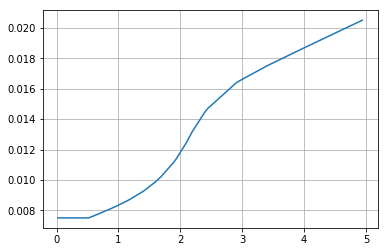

In [11]:
plt.plot(crv_obj.t, r(crv_obj.t))
plt.grid(True)
plt.show();